### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Context

- **Customer centricity**: need to measure and manage customer value
- CLV is important, but it requires a **statistical model** 
- Valuable to have **auditable performance measures**

#### Key Performance Indicators (KPIs)

Calculate “from scratch”: 
1. Monthly sales over time
2. Total customers acquired 
3. Customer acquisition cost (CAC)
4. Distribution of spend per purchase
5. Initial versus repeat sales volume
6. Initial versus repeat average order value (AOV)
7. Sales and AOV by source
8. First-purchase profitability
9. Cohorted sales (the “C3”)
10. Revenue retention curves
11. Cumulative spend per customer
12. Distribution of total spend by customer
13. Customer concentration (“Pareto”) chart 

What they summarize: 
1. Growth
2. Unit costs
3. Unit profitability (unit economic performance)
4. Retention
5. Heterogeneity (customers, time)

### Analysis

#### Input Transaction Logs Data

In [92]:
# Import transaction log, identify & set header, omit customer source data, set order_date as datetime dtype
df = pd.read_csv("data\\transaction-log-example.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['cust_id','order_date', 'net_sales'], 
                 parse_dates=['order_date'],
                 index_col=['order_date'])
df.head()

,cust_id,net_sales
order_date,,
2018-02-16,cust16647,108.784
2018-03-28,cust17852,117.000
2018-09-27,cust17852,315.900
2019-03-08,cust17852,159.250
2016-05-18,cust588,298.350


#### 1. Total monthly sales

- **What**: total sales across all customers each month
- **Why**: most standard, commonly-used growth metric (and it matters!)

**Analysis**: Data shows seasonality with relatively higher sales from October through December as compared to the rest of the year. Data also shows sales are rising year-on-year as we compare across each month. 

In [ ]:
GB = df.groupby([(df.index.year), (df.index.month)])['net_sales'].sum()
GB.unstack()

order_date,1,2,3,4,5,6,7,8,9,10,11,12
order_date,,,,,,,,,,,,
2016,21395.010,31661.305,38094.407,24398.595,36170.030,83308.498,81053.024,111414.979,119505.412,161253.287,223141.646,243675.627
2017,124408.180,132210.728,195413.972,202013.188,237466.827,241425.470,222988.766,234852.293,284023.233,411017.581,548646.332,757308.032
2018,307756.319,316357.886,376486.838,429182.598,555779.198,542620.845,563051.736,614858.790,693434.443,738637.185,733041.049,1013547.405
2019,510834.298,560820.260,691195.674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


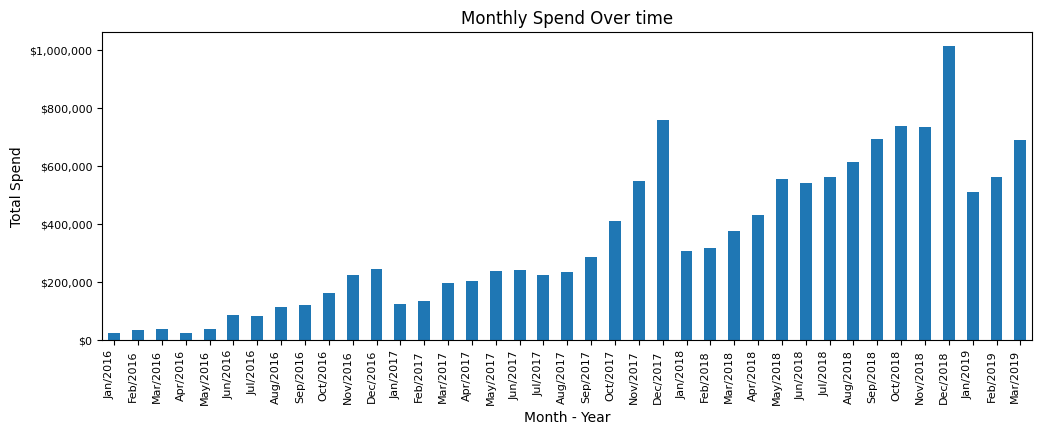

In [ ]:
from matplotlib.ticker import FuncFormatter

ax = GB.plot(kind='bar',  
            figsize=(12,4),
            title="Monthly Spend Over time",
            xlabel='Month - Year',
            ylabel='Total Spend',
            fontsize=8)

ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in GB.index], 
                   rotation=90, 
                   ha='right')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))

#### 2. Monthly Customer Acquisitions